# ELMo


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Masking
from tqdm import tqdm

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed

import joblib  # Para guardar y cargar archivos binarios
import os
import math
import json

##Datos

In [ ]:
df = pd.read_csv("/content/data_limpia_NV.csv", encoding='latin-1')
df = df.dropna()

In [ ]:
df['reviewText'] = df['reviewText'].astype('string')
df['rating'] = df['rating'].astype('int')

In [ ]:
# sparamos los rating con 0 menores iguales a 3 y con 1 mayores a 3
df['rating'].value_counts()

,count
rating,
5,64110
4,19357
3,8755
2,4151
1,3480


In [ ]:
df.loc[df['rating'] < 3, 'rating'] = 0
df.loc[df['rating'] == 3, 'rating'] = 1
df.loc[df['rating'] > 3, 'rating'] = 2

In [ ]:
df['rating'].value_counts()

,count
rating,
2,83467
1,8755
0,7631


In [ ]:
# Separamos la data en train y test y Val
X = df[['reviewText']]
y = df[['rating']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2 ,random_state=1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5 ,random_state=1, stratify=y_val)

## Modelo ELMo

In [ ]:
elmo = hub.load("https://tfhub.dev/google/elmo/3")

In [ ]:
def save_embeddings(embeddings, output_file):
    os.makedirs(os.path.dirname(output_file), exist_ok=True)  # Crear directorio si no existe
    joblib.dump(embeddings, output_file)
    print(f"Embeddings guardados en: {output_file}")

def load_embeddings(input_file):
    if os.path.exists(input_file):
        embeddings = joblib.load(input_file)
        print(f"Embeddings cargados desde: {input_file}")
        return embeddings
    else:
        print(f"El archivo {input_file} no existe.")
        return None

In [ ]:
class vector_batch:

  def __init__(self, id, textos):
    self.id = id
    self.textos = textos
    self.vec = None

In [ ]:
# Model V1
def elmo_vectors(vector_batch):
  vector_batch.vec =  elmo.signatures['default'](tf.constant(vector_batch.textos))['elmo']
  return vector_batch

def pad_and_concat_embeddings(embeddings, max_len=340):
    embeddings_padded = []

    for emb in embeddings:
        current_len = emb.shape[1]

        # Si la secuencia es más larga que max_len, truncarla
        if current_len > max_len:
            emb_truncated = emb[:, :max_len, :]
        # Si la secuencia es más corta que max_len, hacer padding con ceros
        elif current_len < max_len:
            pad_width = max_len - current_len
            emb_truncated = np.pad(emb, ((0, 0), (0, pad_width), (0, 0)), 'constant')
        else:
            emb_truncated = emb

        embeddings_padded.append(emb_truncated)

    # Concatenar todas las secuencias
    embeddings_concatenated = np.vstack(embeddings_padded)

    return embeddings_concatenated


def parallel_elmo_vectors(textos, batch_size=32, num_workers=4, max_len=340):
    batches = [vector_batch(i,textos[i:i + batch_size]) for i in range(0, len(textos), batch_size)]
    embeddings = []

    # Usar concurrent.futures para procesamiento en paralelo
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(elmo_vectors, batch) for batch in batches]

        # Mostrar barra de progreso durante el procesamiento
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(batches), desc="Procesando lotes en paralelo"):
            try:
                result = future.result()  # Obtener el resultado del lote
            except Exception as e:
                print(f"Error al procesar el lote {future.id}: {e}")

    return batches

In [ ]:
def concatenar_embeddings(batches, max_len=340):
  # Ordenar los batches por el atributo 'id' para asegurar el orden correcto
  batches_ordenados = sorted(batches, key=lambda x: x.id)

  embeddings = []
  textos_originales = []

  # Concatenar embeddings y textos originales
  for batch in batches_ordenados:
      if batch.vec is not None:
          # Agregar los embeddings sin apilar más de lo necesario
          embeddings.append(batch.vec)
          textos_originales.extend(batch.textos)  # Concatenar los textos originales

  # Aplanar los embeddings si es necesario, pero manteniendo la estructura de batches
  embeddings_concatenated = pad_and_concat_embeddings(embeddings, max_len=max_len)

  return embeddings_concatenated, textos_originales

def create_new_model():
  # Definir el modelo secuencial con LSTM
  modelo = Sequential([
      Masking(mask_value=0.0, input_shape=(340, 1024)),  # Para manejar secuencias más cortas que 340 palabras
      LSTM(128),  # LSTM para capturar relaciones en la secuencia de embeddings
      Dropout(0.5),
      Dense(3, activation='softmax')  # Tres clases: positivo, neutro, negativo
  ])

  # Compilar el modelo
  modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return modelo

# Entrenamiendo por partes
def fit_by_baches(data_train_x, data_train_y, data_val_x, data_val_y ,skip = 0, ruta_model = None, long_data = 200 ,batch_size = 32, epochs  = 5, out_path = ""):
  # Inicializar el historial
  historial_completo = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

  if ruta_model is not None:
    model = load_model(ruta_model)
  else:
    model = create_new_model()

  j = int(skip*long_data/10)
  aux = int(long_data /10)

  # Asume que tienes tus datos divididos
  for i in range(skip*long_data, len(data_train_x), long_data):
    print(f"data_procesada: {i}")
    # Selecciona un lote de datos
    X_batch_train = data_train_x[i:i+long_data]
    y_batch_train = data_train_y[i:i+long_data]

    X_batch_val = data_val_x[j:j+aux]
    y_batch_val = data_val_y[j:j+aux]

    list_vec_train = parallel_elmo_vectors(X_batch_train['reviewText'].astype(str).values.tolist(), 100,10)
    list_vec_val= parallel_elmo_vectors(X_batch_val['reviewText'].astype(str).values.tolist(), 100,10)

    emb_train, text_train = concatenar_embeddings(list_vec_train, max_len=340)
    emb_val, text_val = concatenar_embeddings(list_vec_val, max_len=340)

    # Entrena el modelo en el lote actual
    history = model.fit(emb_train, y_batch_train, epochs=epochs, batch_size=batch_size, validation_data=(emb_val, y_batch_val))

    # Guarda los pesos después de cada lote
    model.save(f'{out_path}modelo_parcial_{i}.keras')

    # Acumular los resultados del historial
    for key in history.history:
      historial_completo[key].extend(history.history[key])

    with open(f'{out_path}historial_entrenamiento.json', 'w') as f:
      json.dump(historial_completo, f)
    # Opción: Vaciar la memoria (sólo si es necesario)
    # import gc
    # gc.collect()

    j += aux

  return model, historial_completo

In [ ]:
# p = 1000
data_train_x =  X_train
data_train_y = y_train
data_val_x = X_val
data_val_y = y_val
skip = 47
ruta_model = "/content/drive/MyDrive/Proyecto-Tesis/Scripts/Adicionales/Modelo_ELMo/Model/modelo_parcial_46000.keras"
long_data = 1000
out_path = "/content/drive/MyDrive/Proyecto-Tesis/Scripts/Adicionales/Modelo_ELMo/ModelPart2/"
modelo, history = fit_by_baches(data_train_x, data_train_y, data_val_x, data_val_y, skip=skip , ruta_model=ruta_model, long_data=long_data, out_path=out_path)

data_procesada: 47000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:28<00:00, 28.03s/it]


Epoch 1/5
32/32 [==============================] - 18s 441ms/step - loss: 0.5808 - accuracy: 0.8270 - val_loss: 0.5957 - val_accuracy: 0.8200
Epoch 2/5
32/32 [==============================] - 13s 392ms/step - loss: 0.5788 - accuracy: 0.8280 - val_loss: 0.5955 - val_accuracy: 0.8200
Epoch 3/5
32/32 [==============================] - 12s 384ms/step - loss: 0.5830 - accuracy: 0.8270 - val_loss: 0.5950 - val_accuracy: 0.8200
Epoch 4/5
32/32 [==============================] - 12s 380ms/step - loss: 0.5765 - accuracy: 0.8270 - val_loss: 0.5850 - val_accuracy: 0.8200
Epoch 5/5
32/32 [==============================] - 12s 380ms/step - loss: 0.5744 - accuracy: 0.8280 - val_loss: 0.5810 - val_accuracy: 0.8200
data_procesada: 48000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:09<00:00,  9.85s/it]


Epoch 1/5
32/32 [==============================] - 13s 389ms/step - loss: 0.5683 - accuracy: 0.8310 - val_loss: 0.6163 - val_accuracy: 0.8100
Epoch 2/5
32/32 [==============================] - 12s 378ms/step - loss: 0.5560 - accuracy: 0.8330 - val_loss: 0.6134 - val_accuracy: 0.8100
Epoch 3/5
32/32 [==============================] - 12s 375ms/step - loss: 0.5584 - accuracy: 0.8330 - val_loss: 0.6168 - val_accuracy: 0.8100
Epoch 4/5
32/32 [==============================] - 12s 375ms/step - loss: 0.5524 - accuracy: 0.8350 - val_loss: 0.6225 - val_accuracy: 0.8100
Epoch 5/5
32/32 [==============================] - 12s 377ms/step - loss: 0.5516 - accuracy: 0.8340 - val_loss: 0.6173 - val_accuracy: 0.8100
data_procesada: 49000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:16<00:00, 16.42s/it]


Epoch 1/5
32/32 [==============================] - 12s 383ms/step - loss: 0.5261 - accuracy: 0.8520 - val_loss: 0.6166 - val_accuracy: 0.8100
Epoch 2/5
32/32 [==============================] - 12s 376ms/step - loss: 0.5197 - accuracy: 0.8530 - val_loss: 0.6078 - val_accuracy: 0.8100
Epoch 3/5
32/32 [==============================] - 12s 380ms/step - loss: 0.5018 - accuracy: 0.8530 - val_loss: 0.6149 - val_accuracy: 0.8100
Epoch 4/5
32/32 [==============================] - 12s 383ms/step - loss: 0.5112 - accuracy: 0.8530 - val_loss: 0.6263 - val_accuracy: 0.8100
Epoch 5/5
32/32 [==============================] - 12s 387ms/step - loss: 0.5084 - accuracy: 0.8560 - val_loss: 0.6321 - val_accuracy: 0.8100
data_procesada: 50000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:14<00:00, 14.04s/it]


Epoch 1/5
32/32 [==============================] - 13s 386ms/step - loss: 0.5541 - accuracy: 0.8370 - val_loss: 0.4970 - val_accuracy: 0.8600
Epoch 2/5
32/32 [==============================] - 12s 379ms/step - loss: 0.5501 - accuracy: 0.8390 - val_loss: 0.4940 - val_accuracy: 0.8600
Epoch 3/5
32/32 [==============================] - 12s 379ms/step - loss: 0.5502 - accuracy: 0.8400 - val_loss: 0.4936 - val_accuracy: 0.8600
Epoch 4/5
32/32 [==============================] - 12s 375ms/step - loss: 0.5444 - accuracy: 0.8420 - val_loss: 0.4910 - val_accuracy: 0.8600
Epoch 5/5
32/32 [==============================] - 12s 379ms/step - loss: 0.5467 - accuracy: 0.8420 - val_loss: 0.4924 - val_accuracy: 0.8600
data_procesada: 51000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:53<00:00, 53.78s/it]


Epoch 1/5
32/32 [==============================] - 13s 397ms/step - loss: 0.6248 - accuracy: 0.8070 - val_loss: 0.5030 - val_accuracy: 0.8600
Epoch 2/5
32/32 [==============================] - 12s 378ms/step - loss: 0.6169 - accuracy: 0.8100 - val_loss: 0.4991 - val_accuracy: 0.8700
Epoch 3/5
32/32 [==============================] - 12s 380ms/step - loss: 0.6128 - accuracy: 0.8120 - val_loss: 0.4964 - val_accuracy: 0.8600
Epoch 4/5
32/32 [==============================] - 12s 378ms/step - loss: 0.6146 - accuracy: 0.8130 - val_loss: 0.5010 - val_accuracy: 0.8600
Epoch 5/5
32/32 [==============================] - 12s 378ms/step - loss: 0.6088 - accuracy: 0.8150 - val_loss: 0.5045 - val_accuracy: 0.8600
data_procesada: 52000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:20<00:00, 20.83s/it]


Epoch 1/5
32/32 [==============================] - 13s 388ms/step - loss: 0.5763 - accuracy: 0.8290 - val_loss: 0.6605 - val_accuracy: 0.7900
Epoch 2/5
32/32 [==============================] - 12s 379ms/step - loss: 0.5735 - accuracy: 0.8290 - val_loss: 0.6630 - val_accuracy: 0.7900
Epoch 3/5
32/32 [==============================] - 12s 382ms/step - loss: 0.5697 - accuracy: 0.8340 - val_loss: 0.6624 - val_accuracy: 0.7900
Epoch 4/5
32/32 [==============================] - 12s 382ms/step - loss: 0.5692 - accuracy: 0.8320 - val_loss: 0.6675 - val_accuracy: 0.7900
Epoch 5/5
32/32 [==============================] - 12s 383ms/step - loss: 0.5647 - accuracy: 0.8340 - val_loss: 0.6629 - val_accuracy: 0.7900
data_procesada: 53000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:17<00:00, 17.82s/it]


Epoch 1/5
32/32 [==============================] - 12s 383ms/step - loss: 0.5411 - accuracy: 0.8430 - val_loss: 0.4636 - val_accuracy: 0.8700
Epoch 2/5
32/32 [==============================] - 12s 380ms/step - loss: 0.5337 - accuracy: 0.8440 - val_loss: 0.4571 - val_accuracy: 0.8800
Epoch 3/5
32/32 [==============================] - 12s 387ms/step - loss: 0.5337 - accuracy: 0.8490 - val_loss: 0.4535 - val_accuracy: 0.8800
Epoch 4/5
32/32 [==============================] - 12s 378ms/step - loss: 0.5266 - accuracy: 0.8500 - val_loss: 0.4323 - val_accuracy: 0.8800
Epoch 5/5
32/32 [==============================] - 12s 378ms/step - loss: 0.5274 - accuracy: 0.8490 - val_loss: 0.4388 - val_accuracy: 0.8800
data_procesada: 54000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:22<00:00, 22.81s/it]


Epoch 1/5
32/32 [==============================] - 13s 386ms/step - loss: 0.5718 - accuracy: 0.8260 - val_loss: 0.4404 - val_accuracy: 0.8900
Epoch 2/5
32/32 [==============================] - 12s 382ms/step - loss: 0.5623 - accuracy: 0.8260 - val_loss: 0.4453 - val_accuracy: 0.8900
Epoch 3/5
32/32 [==============================] - 12s 375ms/step - loss: 0.5573 - accuracy: 0.8300 - val_loss: 0.4469 - val_accuracy: 0.8900
Epoch 4/5
32/32 [==============================] - 12s 375ms/step - loss: 0.5592 - accuracy: 0.8300 - val_loss: 0.4405 - val_accuracy: 0.8900
Epoch 5/5
32/32 [==============================] - 12s 379ms/step - loss: 0.5536 - accuracy: 0.8300 - val_loss: 0.4437 - val_accuracy: 0.8900
data_procesada: 55000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:40<00:00, 40.37s/it]


Epoch 1/5
32/32 [==============================] - 12s 383ms/step - loss: 0.5624 - accuracy: 0.8240 - val_loss: 0.5668 - val_accuracy: 0.8200
Epoch 2/5
32/32 [==============================] - 12s 377ms/step - loss: 0.5455 - accuracy: 0.8260 - val_loss: 0.5590 - val_accuracy: 0.8200
Epoch 3/5
32/32 [==============================] - 12s 378ms/step - loss: 0.5546 - accuracy: 0.8260 - val_loss: 0.5627 - val_accuracy: 0.8200
Epoch 4/5
32/32 [==============================] - 12s 379ms/step - loss: 0.5459 - accuracy: 0.8280 - val_loss: 0.5482 - val_accuracy: 0.8200
Epoch 5/5
32/32 [==============================] - 12s 375ms/step - loss: 0.5255 - accuracy: 0.8260 - val_loss: 0.5574 - val_accuracy: 0.8200
data_procesada: 56000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:30<00:00, 30.33s/it]


Epoch 1/5
32/32 [==============================] - 13s 401ms/step - loss: 0.4940 - accuracy: 0.8520 - val_loss: 0.4178 - val_accuracy: 0.8800
Epoch 2/5
32/32 [==============================] - 12s 381ms/step - loss: 0.4709 - accuracy: 0.8520 - val_loss: 0.4115 - val_accuracy: 0.8800
Epoch 3/5
32/32 [==============================] - 12s 378ms/step - loss: 0.4455 - accuracy: 0.8550 - val_loss: 0.4001 - val_accuracy: 0.8700
Epoch 4/5
32/32 [==============================] - 12s 381ms/step - loss: 0.4384 - accuracy: 0.8540 - val_loss: 0.4264 - val_accuracy: 0.8800
Epoch 5/5
32/32 [==============================] - 12s 380ms/step - loss: 0.4201 - accuracy: 0.8540 - val_loss: 0.4201 - val_accuracy: 0.8800
data_procesada: 57000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:12<00:00, 12.01s/it]


Epoch 1/5
32/32 [==============================] - 14s 442ms/step - loss: 0.5071 - accuracy: 0.8510 - val_loss: 0.6093 - val_accuracy: 0.7900
Epoch 2/5
32/32 [==============================] - 13s 393ms/step - loss: 0.4621 - accuracy: 0.8540 - val_loss: 0.6207 - val_accuracy: 0.7900
Epoch 3/5
32/32 [==============================] - 12s 381ms/step - loss: 0.4444 - accuracy: 0.8530 - val_loss: 0.6118 - val_accuracy: 0.7900
Epoch 4/5
32/32 [==============================] - 12s 380ms/step - loss: 0.4203 - accuracy: 0.8520 - val_loss: 0.6525 - val_accuracy: 0.7900
Epoch 5/5
32/32 [==============================] - 12s 382ms/step - loss: 0.3956 - accuracy: 0.8660 - val_loss: 0.6242 - val_accuracy: 0.7900
data_procesada: 58000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:11<00:00, 11.53s/it]


Epoch 1/5
32/32 [==============================] - 13s 387ms/step - loss: 0.5193 - accuracy: 0.8310 - val_loss: 0.5721 - val_accuracy: 0.7700
Epoch 2/5
32/32 [==============================] - 12s 376ms/step - loss: 0.4805 - accuracy: 0.8340 - val_loss: 0.6113 - val_accuracy: 0.7700
Epoch 3/5
32/32 [==============================] - 12s 380ms/step - loss: 0.4577 - accuracy: 0.8330 - val_loss: 0.5669 - val_accuracy: 0.7700
Epoch 4/5
32/32 [==============================] - 12s 380ms/step - loss: 0.4098 - accuracy: 0.8460 - val_loss: 0.5724 - val_accuracy: 0.8100
Epoch 5/5
32/32 [==============================] - 12s 377ms/step - loss: 0.3794 - accuracy: 0.8520 - val_loss: 0.6975 - val_accuracy: 0.7700
data_procesada: 59000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:12<00:00, 12.61s/it]


Epoch 1/5
32/32 [==============================] - 12s 385ms/step - loss: 0.5116 - accuracy: 0.8350 - val_loss: 0.4923 - val_accuracy: 0.8300
Epoch 2/5
32/32 [==============================] - 12s 376ms/step - loss: 0.4544 - accuracy: 0.8380 - val_loss: 0.5169 - val_accuracy: 0.8400
Epoch 3/5
32/32 [==============================] - 12s 377ms/step - loss: 0.4211 - accuracy: 0.8400 - val_loss: 0.5606 - val_accuracy: 0.8300
Epoch 4/5
32/32 [==============================] - 12s 376ms/step - loss: 0.3727 - accuracy: 0.8620 - val_loss: 0.5957 - val_accuracy: 0.7700
Epoch 5/5
32/32 [==============================] - 12s 376ms/step - loss: 0.3351 - accuracy: 0.8720 - val_loss: 0.5978 - val_accuracy: 0.7800
data_procesada: 60000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:09<00:00,  9.57s/it]


Epoch 1/5
32/32 [==============================] - 13s 386ms/step - loss: 0.5032 - accuracy: 0.8370 - val_loss: 0.4971 - val_accuracy: 0.8300
Epoch 2/5
32/32 [==============================] - 12s 378ms/step - loss: 0.4463 - accuracy: 0.8430 - val_loss: 0.4755 - val_accuracy: 0.8400
Epoch 3/5
32/32 [==============================] - 12s 376ms/step - loss: 0.4061 - accuracy: 0.8450 - val_loss: 0.4683 - val_accuracy: 0.8200
Epoch 4/5
32/32 [==============================] - 12s 375ms/step - loss: 0.3692 - accuracy: 0.8640 - val_loss: 0.5013 - val_accuracy: 0.8000
Epoch 5/5
32/32 [==============================] - 12s 379ms/step - loss: 0.3179 - accuracy: 0.8850 - val_loss: 0.4995 - val_accuracy: 0.8100
data_procesada: 61000


Procesando lotes en paralelo: 100%|██████████| 1/1 [01:04<00:00, 64.02s/it]


Epoch 1/5
32/32 [==============================] - 13s 396ms/step - loss: 0.4291 - accuracy: 0.8610 - val_loss: 0.6156 - val_accuracy: 0.8000
Epoch 2/5
32/32 [==============================] - 12s 379ms/step - loss: 0.3768 - accuracy: 0.8630 - val_loss: 0.6010 - val_accuracy: 0.8000
Epoch 3/5
32/32 [==============================] - 12s 378ms/step - loss: 0.3286 - accuracy: 0.8760 - val_loss: 0.7767 - val_accuracy: 0.8100
Epoch 4/5
32/32 [==============================] - 12s 378ms/step - loss: 0.2932 - accuracy: 0.8810 - val_loss: 0.7398 - val_accuracy: 0.7800
Epoch 5/5
32/32 [==============================] - 12s 379ms/step - loss: 0.2534 - accuracy: 0.9010 - val_loss: 0.7190 - val_accuracy: 0.7200
data_procesada: 62000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:10<00:00, 10.94s/it]


Epoch 1/5
32/32 [==============================] - 13s 386ms/step - loss: 0.5092 - accuracy: 0.8240 - val_loss: 0.4990 - val_accuracy: 0.8300
Epoch 2/5
32/32 [==============================] - 12s 376ms/step - loss: 0.4070 - accuracy: 0.8450 - val_loss: 0.4920 - val_accuracy: 0.8300
Epoch 3/5
32/32 [==============================] - 12s 374ms/step - loss: 0.3550 - accuracy: 0.8570 - val_loss: 0.5308 - val_accuracy: 0.8000
Epoch 4/5
32/32 [==============================] - 12s 374ms/step - loss: 0.2885 - accuracy: 0.8740 - val_loss: 0.5827 - val_accuracy: 0.7400
Epoch 5/5
32/32 [==============================] - 12s 380ms/step - loss: 0.2758 - accuracy: 0.8910 - val_loss: 0.6049 - val_accuracy: 0.7700
data_procesada: 63000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:27<00:00, 27.12s/it]


Epoch 1/5
32/32 [==============================] - 12s 384ms/step - loss: 0.4665 - accuracy: 0.8460 - val_loss: 0.4396 - val_accuracy: 0.8500
Epoch 2/5
32/32 [==============================] - 12s 378ms/step - loss: 0.3918 - accuracy: 0.8550 - val_loss: 0.4268 - val_accuracy: 0.8500
Epoch 3/5
32/32 [==============================] - 12s 381ms/step - loss: 0.3349 - accuracy: 0.8700 - val_loss: 0.4479 - val_accuracy: 0.8400
Epoch 4/5
32/32 [==============================] - 12s 381ms/step - loss: 0.3022 - accuracy: 0.8870 - val_loss: 0.4969 - val_accuracy: 0.8500
Epoch 5/5
32/32 [==============================] - 12s 379ms/step - loss: 0.2936 - accuracy: 0.8880 - val_loss: 0.4659 - val_accuracy: 0.8500
data_procesada: 64000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:28<00:00, 28.76s/it]


Epoch 1/5
32/32 [==============================] - 12s 384ms/step - loss: 0.5247 - accuracy: 0.8070 - val_loss: 0.5766 - val_accuracy: 0.7900
Epoch 2/5
32/32 [==============================] - 12s 378ms/step - loss: 0.4375 - accuracy: 0.8310 - val_loss: 0.5802 - val_accuracy: 0.7800
Epoch 3/5
32/32 [==============================] - 12s 380ms/step - loss: 0.3951 - accuracy: 0.8490 - val_loss: 0.5938 - val_accuracy: 0.7900
Epoch 4/5
32/32 [==============================] - 12s 376ms/step - loss: 0.3485 - accuracy: 0.8640 - val_loss: 0.6211 - val_accuracy: 0.7900
Epoch 5/5
32/32 [==============================] - 12s 376ms/step - loss: 0.2983 - accuracy: 0.8880 - val_loss: 0.6577 - val_accuracy: 0.7800
data_procesada: 65000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:12<00:00, 12.10s/it]


Epoch 1/5
32/32 [==============================] - 13s 387ms/step - loss: 0.5359 - accuracy: 0.8290 - val_loss: 0.6323 - val_accuracy: 0.8000
Epoch 2/5
32/32 [==============================] - 12s 378ms/step - loss: 0.4265 - accuracy: 0.8540 - val_loss: 0.6236 - val_accuracy: 0.8000
Epoch 3/5
32/32 [==============================] - 12s 376ms/step - loss: 0.3798 - accuracy: 0.8670 - val_loss: 0.6283 - val_accuracy: 0.7900
Epoch 4/5
32/32 [==============================] - 12s 378ms/step - loss: 0.3186 - accuracy: 0.8930 - val_loss: 0.7001 - val_accuracy: 0.8000
Epoch 5/5
32/32 [==============================] - 12s 378ms/step - loss: 0.2627 - accuracy: 0.9060 - val_loss: 0.7458 - val_accuracy: 0.7800
data_procesada: 66000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:13<00:00, 13.12s/it]


Epoch 1/5
32/32 [==============================] - 13s 400ms/step - loss: 0.5505 - accuracy: 0.8090 - val_loss: 0.5646 - val_accuracy: 0.7700
Epoch 2/5
32/32 [==============================] - 12s 376ms/step - loss: 0.4469 - accuracy: 0.8420 - val_loss: 0.5697 - val_accuracy: 0.8000
Epoch 3/5
32/32 [==============================] - 12s 375ms/step - loss: 0.4026 - accuracy: 0.8580 - val_loss: 0.6120 - val_accuracy: 0.7600
Epoch 4/5
32/32 [==============================] - 12s 380ms/step - loss: 0.3572 - accuracy: 0.8690 - val_loss: 0.6227 - val_accuracy: 0.7700
Epoch 5/5
32/32 [==============================] - 12s 380ms/step - loss: 0.3193 - accuracy: 0.8890 - val_loss: 0.6493 - val_accuracy: 0.8200
data_procesada: 67000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:16<00:00, 16.70s/it]


Epoch 1/5
32/32 [==============================] - 12s 382ms/step - loss: 0.5887 - accuracy: 0.8000 - val_loss: 0.5256 - val_accuracy: 0.8000
Epoch 2/5
32/32 [==============================] - 12s 377ms/step - loss: 0.4795 - accuracy: 0.8250 - val_loss: 0.5058 - val_accuracy: 0.8200
Epoch 3/5
32/32 [==============================] - 12s 375ms/step - loss: 0.4405 - accuracy: 0.8380 - val_loss: 0.5363 - val_accuracy: 0.8300
Epoch 4/5
32/32 [==============================] - 12s 377ms/step - loss: 0.3759 - accuracy: 0.8610 - val_loss: 0.5354 - val_accuracy: 0.7800
Epoch 5/5
32/32 [==============================] - 12s 373ms/step - loss: 0.3332 - accuracy: 0.8770 - val_loss: 0.5766 - val_accuracy: 0.8100
data_procesada: 68000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:21<00:00, 21.31s/it]


Epoch 1/5
32/32 [==============================] - 12s 383ms/step - loss: 0.5299 - accuracy: 0.8350 - val_loss: 0.4742 - val_accuracy: 0.8300
Epoch 2/5
32/32 [==============================] - 12s 378ms/step - loss: 0.4187 - accuracy: 0.8690 - val_loss: 0.4461 - val_accuracy: 0.8500
Epoch 3/5
32/32 [==============================] - 12s 375ms/step - loss: 0.3601 - accuracy: 0.8800 - val_loss: 0.4652 - val_accuracy: 0.8400
Epoch 4/5
32/32 [==============================] - 12s 378ms/step - loss: 0.3042 - accuracy: 0.8990 - val_loss: 0.5850 - val_accuracy: 0.7800
Epoch 5/5
32/32 [==============================] - 12s 378ms/step - loss: 0.2539 - accuracy: 0.9100 - val_loss: 0.6307 - val_accuracy: 0.8100
data_procesada: 69000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:12<00:00, 12.09s/it]


Epoch 1/5
32/32 [==============================] - 13s 402ms/step - loss: 0.5633 - accuracy: 0.8190 - val_loss: 0.4234 - val_accuracy: 0.8700
Epoch 2/5
32/32 [==============================] - 12s 380ms/step - loss: 0.4277 - accuracy: 0.8440 - val_loss: 0.4185 - val_accuracy: 0.8600
Epoch 3/5
32/32 [==============================] - 12s 376ms/step - loss: 0.3893 - accuracy: 0.8610 - val_loss: 0.4261 - val_accuracy: 0.8500
Epoch 4/5
32/32 [==============================] - 12s 375ms/step - loss: 0.3457 - accuracy: 0.8730 - val_loss: 0.4815 - val_accuracy: 0.8300
Epoch 5/5
32/32 [==============================] - 12s 377ms/step - loss: 0.3058 - accuracy: 0.8960 - val_loss: 0.4484 - val_accuracy: 0.8500
data_procesada: 70000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:19<00:00, 19.32s/it]


Epoch 1/5
32/32 [==============================] - 13s 387ms/step - loss: 0.4745 - accuracy: 0.8590 - val_loss: 0.4859 - val_accuracy: 0.8500
Epoch 2/5
32/32 [==============================] - 12s 378ms/step - loss: 0.3694 - accuracy: 0.8890 - val_loss: 0.4508 - val_accuracy: 0.8600
Epoch 3/5
32/32 [==============================] - 12s 377ms/step - loss: 0.3101 - accuracy: 0.9030 - val_loss: 0.4516 - val_accuracy: 0.8400
Epoch 4/5
32/32 [==============================] - 12s 378ms/step - loss: 0.2669 - accuracy: 0.9150 - val_loss: 0.4862 - val_accuracy: 0.8300
Epoch 5/5
32/32 [==============================] - 12s 374ms/step - loss: 0.2328 - accuracy: 0.9210 - val_loss: 0.4919 - val_accuracy: 0.8500
data_procesada: 71000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:19<00:00, 19.49s/it]


Epoch 1/5
32/32 [==============================] - 13s 390ms/step - loss: 0.5662 - accuracy: 0.8250 - val_loss: 0.3399 - val_accuracy: 0.9100
Epoch 2/5
32/32 [==============================] - 12s 379ms/step - loss: 0.4205 - accuracy: 0.8700 - val_loss: 0.2772 - val_accuracy: 0.9300
Epoch 3/5
32/32 [==============================] - 12s 377ms/step - loss: 0.3472 - accuracy: 0.8790 - val_loss: 0.3110 - val_accuracy: 0.9100
Epoch 4/5
32/32 [==============================] - 12s 379ms/step - loss: 0.3091 - accuracy: 0.8920 - val_loss: 0.3071 - val_accuracy: 0.9100
Epoch 5/5
32/32 [==============================] - 12s 378ms/step - loss: 0.2637 - accuracy: 0.9020 - val_loss: 0.3202 - val_accuracy: 0.9200
data_procesada: 72000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:11<00:00, 11.59s/it]


Epoch 1/5
32/32 [==============================] - 13s 389ms/step - loss: 0.4916 - accuracy: 0.8350 - val_loss: 0.3493 - val_accuracy: 0.8800
Epoch 2/5
32/32 [==============================] - 12s 380ms/step - loss: 0.3638 - accuracy: 0.8670 - val_loss: 0.4469 - val_accuracy: 0.8400
Epoch 3/5
32/32 [==============================] - 12s 379ms/step - loss: 0.3012 - accuracy: 0.8910 - val_loss: 0.4754 - val_accuracy: 0.8000
Epoch 4/5
32/32 [==============================] - 12s 379ms/step - loss: 0.2612 - accuracy: 0.9070 - val_loss: 0.4774 - val_accuracy: 0.8400
Epoch 5/5
32/32 [==============================] - 12s 377ms/step - loss: 0.2253 - accuracy: 0.9150 - val_loss: 0.6185 - val_accuracy: 0.7800
data_procesada: 73000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:08<00:00,  8.92s/it]


Epoch 1/5
32/32 [==============================] - 12s 384ms/step - loss: 0.5254 - accuracy: 0.8340 - val_loss: 0.4492 - val_accuracy: 0.8700
Epoch 2/5
32/32 [==============================] - 12s 379ms/step - loss: 0.4158 - accuracy: 0.8600 - val_loss: 0.3908 - val_accuracy: 0.8700
Epoch 3/5
32/32 [==============================] - 12s 384ms/step - loss: 0.3451 - accuracy: 0.8830 - val_loss: 0.4181 - val_accuracy: 0.8700
Epoch 4/5
32/32 [==============================] - 12s 376ms/step - loss: 0.2995 - accuracy: 0.8940 - val_loss: 0.4588 - val_accuracy: 0.8700
Epoch 5/5
32/32 [==============================] - 12s 378ms/step - loss: 0.2552 - accuracy: 0.9140 - val_loss: 0.5045 - val_accuracy: 0.8400
data_procesada: 74000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:13<00:00, 13.24s/it]


Epoch 1/5
32/32 [==============================] - 12s 381ms/step - loss: 0.5339 - accuracy: 0.8390 - val_loss: 0.3931 - val_accuracy: 0.8800
Epoch 2/5
32/32 [==============================] - 12s 381ms/step - loss: 0.4003 - accuracy: 0.8670 - val_loss: 0.3190 - val_accuracy: 0.8900
Epoch 3/5
32/32 [==============================] - 12s 380ms/step - loss: 0.3356 - accuracy: 0.8950 - val_loss: 0.3083 - val_accuracy: 0.9000
Epoch 4/5
32/32 [==============================] - 12s 379ms/step - loss: 0.2998 - accuracy: 0.9060 - val_loss: 0.3072 - val_accuracy: 0.8900
Epoch 5/5
32/32 [==============================] - 12s 378ms/step - loss: 0.2616 - accuracy: 0.9190 - val_loss: 0.3366 - val_accuracy: 0.8900
data_procesada: 75000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:12<00:00, 12.42s/it]


Epoch 1/5
32/32 [==============================] - 12s 383ms/step - loss: 0.5332 - accuracy: 0.8250 - val_loss: 0.3776 - val_accuracy: 0.8900
Epoch 2/5
32/32 [==============================] - 12s 381ms/step - loss: 0.4008 - accuracy: 0.8660 - val_loss: 0.3676 - val_accuracy: 0.8800
Epoch 3/5
32/32 [==============================] - 12s 381ms/step - loss: 0.3287 - accuracy: 0.8850 - val_loss: 0.3891 - val_accuracy: 0.8700
Epoch 4/5
32/32 [==============================] - 12s 378ms/step - loss: 0.2782 - accuracy: 0.8990 - val_loss: 0.4040 - val_accuracy: 0.8500
Epoch 5/5
32/32 [==============================] - 12s 381ms/step - loss: 0.2429 - accuracy: 0.9080 - val_loss: 0.4648 - val_accuracy: 0.8700
data_procesada: 76000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:18<00:00, 18.23s/it]


Epoch 1/5
32/32 [==============================] - 13s 395ms/step - loss: 0.5482 - accuracy: 0.8120 - val_loss: 0.5363 - val_accuracy: 0.7900
Epoch 2/5
32/32 [==============================] - 12s 381ms/step - loss: 0.3974 - accuracy: 0.8630 - val_loss: 0.5207 - val_accuracy: 0.8400
Epoch 3/5
32/32 [==============================] - 12s 378ms/step - loss: 0.3187 - accuracy: 0.8940 - val_loss: 0.5660 - val_accuracy: 0.8200
Epoch 4/5
32/32 [==============================] - 12s 378ms/step - loss: 0.2936 - accuracy: 0.8980 - val_loss: 0.5755 - val_accuracy: 0.8300
Epoch 5/5
32/32 [==============================] - 12s 379ms/step - loss: 0.2394 - accuracy: 0.9110 - val_loss: 0.6277 - val_accuracy: 0.8100
data_procesada: 77000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:23<00:00, 23.96s/it]


Epoch 1/5
32/32 [==============================] - 12s 385ms/step - loss: 0.5666 - accuracy: 0.8220 - val_loss: 0.6310 - val_accuracy: 0.7800
Epoch 2/5
32/32 [==============================] - 12s 377ms/step - loss: 0.4087 - accuracy: 0.8690 - val_loss: 0.6367 - val_accuracy: 0.7700
Epoch 3/5
32/32 [==============================] - 12s 378ms/step - loss: 0.3334 - accuracy: 0.8900 - val_loss: 0.6486 - val_accuracy: 0.7800
Epoch 4/5
32/32 [==============================] - 12s 377ms/step - loss: 0.2974 - accuracy: 0.8940 - val_loss: 0.7061 - val_accuracy: 0.7700
Epoch 5/5
32/32 [==============================] - 12s 378ms/step - loss: 0.2438 - accuracy: 0.9050 - val_loss: 0.8037 - val_accuracy: 0.7600
data_procesada: 78000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:13<00:00, 13.29s/it]


Epoch 1/5
32/32 [==============================] - 13s 394ms/step - loss: 0.6090 - accuracy: 0.8160 - val_loss: 0.3932 - val_accuracy: 0.9000
Epoch 2/5
32/32 [==============================] - 12s 379ms/step - loss: 0.4770 - accuracy: 0.8430 - val_loss: 0.4591 - val_accuracy: 0.8400
Epoch 3/5
32/32 [==============================] - 12s 380ms/step - loss: 0.4097 - accuracy: 0.8590 - val_loss: 0.4085 - val_accuracy: 0.8900
Epoch 4/5
32/32 [==============================] - 12s 378ms/step - loss: 0.3496 - accuracy: 0.8800 - val_loss: 0.4123 - val_accuracy: 0.8900
Epoch 5/5
32/32 [==============================] - 12s 379ms/step - loss: 0.3164 - accuracy: 0.8890 - val_loss: 0.5028 - val_accuracy: 0.8600
data_procesada: 79000


Procesando lotes en paralelo: 100%|██████████| 1/1 [00:13<00:00, 13.21s/it]


Epoch 1/5
28/28 [==============================] - 11s 389ms/step - loss: 0.4869 - accuracy: 0.8413 - val_loss: 0.4624 - val_accuracy: 0.8300
Epoch 2/5
28/28 [==============================] - 11s 384ms/step - loss: 0.3897 - accuracy: 0.8673 - val_loss: 0.5022 - val_accuracy: 0.8300
Epoch 3/5
28/28 [==============================] - 11s 381ms/step - loss: 0.3401 - accuracy: 0.8832 - val_loss: 0.4868 - val_accuracy: 0.8300
Epoch 4/5
28/28 [==============================] - 11s 381ms/step - loss: 0.2834 - accuracy: 0.9025 - val_loss: 0.4660 - val_accuracy: 0.8300
Epoch 5/5
28/28 [==============================] - 11s 385ms/step - loss: 0.2476 - accuracy: 0.9127 - val_loss: 0.4840 - val_accuracy: 0.8500


In [ ]:
list_vec_test = parallel_elmo_vectors(X_test['reviewText'].astype(str).values.tolist(), 100,10)
emb_test, text_test = concatenar_embeddings(list_vec_test, max_len=340)

Procesando lotes en paralelo: 100%|██████████| 100/100 [20:26<00:00, 12.26s/it]


In [ ]:
# Evaluar el modelo en el conjunto de validación
loss, accuracy = modelo.evaluate(emb_test, y_test)
print(f"Precisión en validación: {accuracy * 100:.2f}%")


313/313 [==============================] - 47s 151ms/step - loss: 0.5286 - accuracy: 0.8310
Precisión en validación: 83.10%


In [ ]:
# el clasificador retorna una probabilidad.
aux_vec = vector_batch(1,['this is such an amazing movie!'])
# Obtener el embedding ELMo para el nuevo comentario
nuevo_embedding = elmo_vectors(aux_vec)

In [ ]:
# Función para hacer padding a un embedding de secuencia
def pad_sequence(embedding, max_len=340):
    # Obtener la longitud actual de la secuencia
    current_len = embedding.shape[1]

    # Si la secuencia es más corta que max_len, agregar padding
    if current_len < max_len:
        # Hacemos padding en el eje de las palabras (dimensión 1)
        padding = np.zeros((embedding.shape[0], max_len - current_len, embedding.shape[2]))
        embedding_padded = np.concatenate([embedding, padding], axis=1)
    else:
        # Si la secuencia es mayor o igual al tamaño esperado, cortamos el exceso
        embedding_padded = embedding[:, :max_len, :]

    return embedding_padded


In [ ]:

# Obtener el embedding ELMo para el texto de prueba
embedding_test = elmo_vectors(vector_batch(1,['this is such an amazing movie!']))
# Hacer padding para que tenga la longitud esperada (340 palabras)
embedding_test_padded = pad_sequence(embedding_test.vec)
# Predecir usando el modelo
prediccion = modelo.predict(embedding_test_padded)
# Mostrar la predicción (probabilidades)
print(prediccion)

1/1 [==============================] - 4s 4s/step
[[0.1034802  0.16859344 0.72792643]]


In [ ]:
tf.keras.utils.plot_model(modelo, show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


dict_keys(['loss', 'val_loss', 'accuracy', 'val_accuracy'])


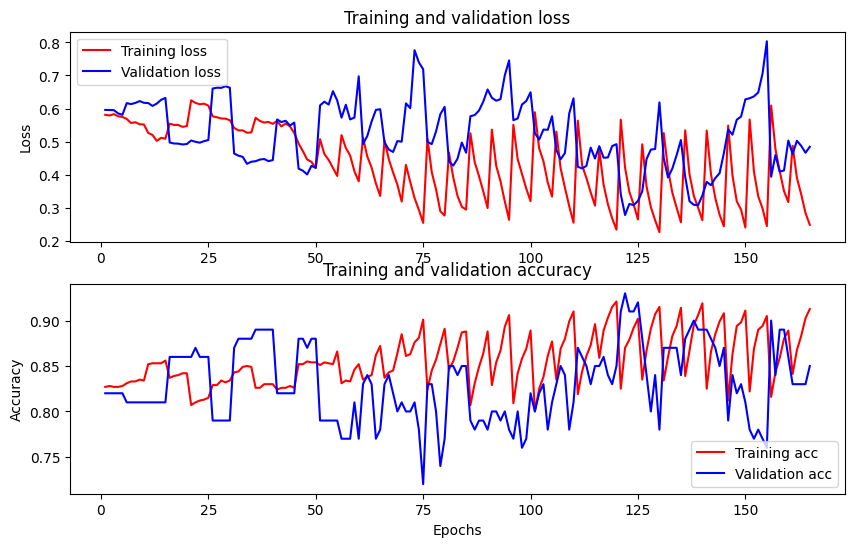

In [ ]:
#Grafico del entrenamiento del modelo
history_dict = history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

##Guardar el Modelo


In [ ]:
dataset_name = 'amazonReview'
saved_model_path = '/content/drive/MyDrive/Proyecto-Tesis/Scripts/Adicionales/{}_elmo.keras'.format(dataset_name.replace('/', '_'))

modelo.save(saved_model_path)

In [ ]:
reloaded_model = tf.keras.models.load_model(saved_model_path, custom_objects={'KerasLayer': hub.KerasLayer})


In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i]}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(pad_sequence(elmo_vectors(vector_batch(1,examples)).vec)))
original_results = tf.sigmoid(modelo(pad_sequence(elmo_vectors(vector_batch(1,examples)).vec)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: [0.525847  0.5420488 0.67435  ]
input: The movie was great!           : score: [0.5692902  0.5727766  0.60536146]
input: The movie was meh.             : score: [0.60844845 0.5827133  0.5560838 ]
input: The movie was okish.           : score: [0.59671026 0.5835274  0.5673268 ]
input: The movie was terrible...      : score: [0.5546816  0.56546247 0.6264539 ]

Results from the model in memory:
input: this is such an amazing movie! : score: [0.525847  0.5420488 0.67435  ]
input: The movie was great!           : score: [0.5692902  0.5727766  0.60536146]
input: The movie was meh.             : score: [0.60844845 0.5827133  0.5560838 ]
input: The movie was okish.           : score: [0.59671026 0.5835274  0.5673268 ]
input: The movie was terrible...      : score: [0.5546816  0.56546247 0.6264539 ]

